In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<img src='images/ej_armadura1 (1).png'>
<img src='images/ej_armadura1 (2).png'>

In [2]:
Lee = np.array([[9, 10, 1, 2],
                [1, 2, 3, 11],
                [3, 11, 4, 12],
                [5, 6, 7, 8],
                [1, 2, 5, 6],
                [3, 11, 7, 8],
                [9, 10, 5, 6],
                [3, 11, 5, 6],
                [4, 12, 7, 8]])


df = pd.DataFrame(Lee)
descripciones_columnas = ['Xa', 'Ya', 'Xb', 'Yb']
nueva_fila_columnas = pd.DataFrame([descripciones_columnas], columns=df.columns)
df_con_descripciones_columnas = pd.concat([nueva_fila_columnas, df], ignore_index=True)
descripciones_filas = ['-','Elemento 1', 'Elemento 2', 'Elemento 3', 'Elemento 4', 'Elemento 5', 'Elemento 6', 'Elemento 7', 'Elemento 8', 'Elemento 9']
df_tabla = pd.DataFrame(descripciones_filas, columns=['Descripción']).join(df_con_descripciones_columnas)
display(df_tabla.style.set_caption('Vectores de ensamble'))

,Descripción,0,1,2,3
0,-,Xa,Ya,Xb,Yb
1,Elemento 1,9,10,1,2
2,Elemento 2,1,2,3,11
3,Elemento 3,3,11,4,12
4,Elemento 4,5,6,7,8
5,Elemento 5,1,2,5,6
6,Elemento 6,3,11,7,8
7,Elemento 7,9,10,5,6
8,Elemento 8,3,11,5,6
9,Elemento 9,4,12,7,8


In [3]:
pulgada = 12  #(1ft = 12in)
A = 6 #Area de cada elemento (in2)
E = 29000  #Modulo de elasticidad del acero (ksi)
AE = A*E
L1 = 15*pulgada  #in
L2 = 20*pulgada  #in
L3 = np.sqrt((L1**2) + (L2**2))
Long_el = [L1, L1, L1, L1, L2, L2, L3, L3, L3]          # longitudes de cada elemento
Ae_elem = np.ones(len(Long_el))*AE         # E por A de cada elemento
angulo_grad = [0, 0, 0, 0, 90, 90, np.tan(np.deg2rad(L2/L1))**(-1), 90+((np.tan(np.deg2rad(L2/L1)))**(-1)), 90+((np.tan(np.deg2rad(L2/L1)))**(-1))]        # angulos de los elementos en radianes
angulo = np.deg2rad(angulo_grad)                        # angulos de los elementos en grados
nglt = 12                                               # Grados de libertad incluidas restricciones 
gdl = 8                                                 # Grados de libertad 
primera_reaccion = 9                                    # Numeración de la primera reacción 
numelem = len(Long_el)                                  # Numero de Elementos
nodes = 6                                               # Numero de nodos (grafico)

P = [0, -30, 0, 0, 10, 0, 0, -30]                       #Vector de Fuerzas externas nodales


In [4]:
kmp = []
def k_elem_2x2(AE,L):
    kmp = [[AE/L, -AE/L], 
        [-AE/L, AE/L]]
    
    return kmp


def T_elem__4x2(alfas):
    Ta = [[np.cos(alfas), 0],
    [np.sin(alfas), 0],
    [0, np.cos(alfas)],
    [0, np.sin(alfas)]]

    return Ta


def Kelem_6GDL_MVA(E,I,G,L,A,f): #Nombre y parametros de la función

    #Declaracion de las constantes
    r = A*E/L
    B = 6*E*I*f/(G*A*L**2)
    kp = 2*E*I/L*(2+B)/(1+2*B)
    ap = 2*E*I/L*1-B/(1-2*B)
    bp = 6*E*I/L**(2)*1/(1+2*B)
    tp = 12*E*I/L**(3)*1/(1+2*B)
    #Declaracion de la matriz de rigidez
    k = [[r, 0, 0, -r, 0, 0],
        [0, tp, bp, 0, -tp, bp],
        [0, bp, kp, 0, -bp, ap],
        [-r, 0, 0, r, 0, 0],
        [0, -tp, -bp, 0, tp, -bp],
        [0, bp, ap, 0, -bp, kp]]
    
    return k

j = 0
k_ele_local = np.zeros((len(Long_el)*2,2))
for i in range (len(Long_el)):
    k_ele_local[j:j+2,:] = k_elem_2x2(Ae_elem[i],Long_el[i])
    j+= 2

k_ele_local_tbla = pd.DataFrame(k_ele_local)
display(k_ele_local_tbla.style.set_caption('Matriz de rigidez Local'))


,0,1
0,966.666667,-966.666667
1,-966.666667,966.666667
2,966.666667,-966.666667
3,-966.666667,966.666667
4,966.666667,-966.666667
5,-966.666667,966.666667
6,966.666667,-966.666667
7,-966.666667,966.666667
8,725.000000,-725.000000
9,-725.000000,725.000000


In [5]:
j=0
Ta = np.zeros((len(Long_el)*4,2))
for i in range (len(angulo)):
    Ta[j:j+4,:] = T_elem__4x2(angulo[i])
    j = j + 4

#Ta = Ta[1:(len(Long_el)*4)-3, 0:2]
Ta_tbla = pd.DataFrame(Ta)
display(Ta_tbla.style.set_caption('Matriz de transformación para cada elemento'))

,0,1
0,1.000000,0.000000
1,0.000000,0.000000
2,0.000000,1.000000
3,0.000000,0.000000
4,1.000000,0.000000
5,0.000000,0.000000
6,0.000000,1.000000
7,0.000000,0.000000
8,1.000000,0.000000
9,0.000000,0.000000


In [6]:
Tat = np.transpose(Ta)
j=0
z=0
Ke_G = np.zeros((len(Long_el)*4,4))
for i in range (len(Long_el)):
    Ke_G[z:z+4,:] = Ta[z:z+4,:] @ k_ele_local[j:j+2,:] @ Tat[:,z:z+4]
    j=j+2
    z=z+4

#Ke_G = Ke_G[0:(len(Long_el)*4)-4, 0:4]
Ke_G_tbl = pd.DataFrame(Ke_G)
display(Ke_G_tbl.style.set_caption('Matriz de rigidez global por cada elemento'))



,0,1,2,3
0,966.666667,0.000000,-966.666667,0.000000
1,0.000000,0.000000,0.000000,0.000000
2,-966.666667,0.000000,966.666667,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,966.666667,0.000000,-966.666667,0.000000
5,0.000000,0.000000,0.000000,0.000000
6,-966.666667,0.000000,966.666667,0.000000
7,0.000000,0.000000,0.000000,0.000000
8,966.666667,0.000000,-966.666667,0.000000
9,0.000000,0.000000,0.000000,0.000000


In [7]:
def Ens(lee,K,S,nglt):
    '''
    Ens vector de ensamble 
    lee vector de colocacion. numerando los grados de libertad para cada elemento 
    K Matrices de Rigides de cada elemento en coordenadas de globales
    S Matriz de rigidez total de la estructura 
    nglt numero de grados de libertad incluido resticciones 
    '''

    ng = len(lee)
    for i in range (ng):                             # contador de filas 
        ii = lee[i-1]
       # if ii>0:                                    # cuanta la posiscion ii en 1,1:2,2..etc
        if ii <= nglt:                             # restringe que que las posicio ii no supere los grados de libertad.
            for j in range (ng):
                jj=lee[j-1]                          # cuanta la posiscion jj en 1,1:2,2..etc
                #if jj>0:
                if jj <= nglt:                 # restringe que que las posicio jj no supere los grados de libertad.
                    S[ii-1,jj-1]=S[ii-1,jj-1]+ K[i-1,j-1]  # ensambla la matriz S con las coordenadas mas la matriz original K de cada miembro
    
    return S



S = np.zeros((nglt, nglt), dtype=int)     # Matriz de rigidez de la estructura (llena de ceros)

j=0
for i in range (len(Long_el)):
    S = Ens(Lee[i,:], Ke_G[j:j+4,:], S, nglt)
    j = j + 4

Tabla = pd.DataFrame(S)
display(Tabla.style.set_caption('Matriz de rigidez Global S'))


,0,1,2,3,4,5,6,7,8,9,10,11
0,1932,0,-966,0,0,0,0,0,-966,0,0,0
1,0,725,0,0,0,-725,0,0,0,0,0,0
2,-966,0,2201,-966,-269,289,0,0,0,0,-289,0
3,0,0,-966,1235,0,0,-269,289,0,0,0,-289
4,0,0,-269,0,1545,0,-966,0,-310,-289,289,0
5,0,-725,289,0,0,1304,0,0,-289,-269,-310,0
6,0,0,0,-269,-966,0,1235,-289,0,0,0,289
7,0,0,0,289,0,0,-289,1035,0,0,-725,-310
8,-966,0,0,0,-310,-289,0,0,1276,289,0,0
9,0,0,0,0,-289,-269,0,0,289,269,0,0


In [8]:
Sll = S[0:gdl, 0:gdl]

Delta_g_indexed = np.zeros(nglt)
Delta_g_indexed[0:len(np.array(P))] = np.linalg.inv(Sll) @ np.array(P)
Delta_g = pd.Series(Delta_g_indexed, index=np.arange(1, len(Delta_g_indexed)+1))
Delta_g_tbl = pd.DataFrame({'Delta_g_ij': Delta_g})
display(Delta_g_tbl.style.set_caption('Desplazamientos globales de los nodos'))

,Delta_g_ij
1,0.022606
2,-0.115760
3,0.045212
4,0.049480
5,0.031156
6,-0.074381
7,0.026888
8,-0.035294
9,0.000000
10,0.000000


In [9]:
j = 0
Delta_g_ij = np.zeros((len(Long_el)*4))
for i in range(len(Long_el)):
    Delta_g_ij[j:j+4] = Delta_g[np.transpose(Lee[i,:])]
    j+=4

Tabla = pd.DataFrame({'Delta_g_ij': Delta_g_ij})
display(Tabla.style.set_caption('Vector de desplazamientos globales por elemento'))

,Delta_g_ij
0,0.000000
1,0.000000
2,0.022606
3,-0.115760
4,0.022606
5,-0.115760
6,0.045212
7,0.000000
8,0.045212
9,0.000000


In [10]:
j=0
z=0
Delta_L_ij = np.zeros(len(Long_el)*2)
for i in range(len(Long_el)):
    Delta_L_ij[z:z+2] = Tat[:,j:j+4] @ Delta_g_ij[j:j+4]
    j+= 4
    z+= 2

Delta_L_ij_tbl = pd.DataFrame({'Delta_L_ij': Delta_L_ij})
display(Delta_L_ij_tbl.style.set_caption('Vector de desplazamientos locales'))

,Delta_L_ij
0,0.000000
1,0.022606
2,0.022606
3,0.045212
4,0.045212
5,0.049480
6,0.031156
7,0.026888
8,-0.115760
9,-0.074381


In [11]:
z=0
acc_elem_L = np.zeros(len(Long_el)*2)
for i in range(len(Long_el)):
    acc_elem_L[z:z+2] = k_ele_local[z:z+2,:] @ Delta_L_ij[z:z+2]
    z+= 2


#Vector de acciones
k = 0
fe_est = np.zeros((numelem*2), dtype=object)
for i in range(numelem):
    if acc_elem_L[k] == 0:
            fe_est[k] = ['NaN']
            fe_est[k+1] = ['NaN']
    else:
        if acc_elem_L[k]>0 and acc_elem_L[k + 1]<0:
            fe_est[k] = ['C']
            fe_est[k+1] = ['C']
        else:
            fe_est[k] = ['T']
            fe_est[k+1] = ['T']
    k+=2


tbl_fe_est = pd.DataFrame({'acc_elem_L': acc_elem_L, 'fe_est': fe_est})
display(tbl_fe_est)

,acc_elem_L,fe_est
0,-21.852652,[T]
1,21.852652,[T]
2,-21.852652,[T]
3,21.852652,[T]
4,-4.125544,[T]
5,4.125544,[T]
6,4.125544,[C]
7,-4.125544,[C]
8,-30.000000,[T]
9,30.000000,[T]


In [12]:
#Graficador

#Vector de Coordenadas & Coordenadas restringidas por nodo
N_XY = np.array([[1, 0,  0, 1, 1],
                [2, 15, 0, 0, 0],
                [3, 30, 0, 0, 1],
                [4, 45, 0, 0, 1],
                [5, 15, 20, 0, 0],
                [6, 30, 20, 0, 0]])

#Matriz de identificacion de nodos por elemento
ID = np.array([[1, 2],
                [2, 3],
                [3, 4],
                [5, 6],
                [1, 5],
                [2, 5],
                [5, 3],
                [3, 6],
                [6, 4]])

#reordenamiento de la matriz 'Delta_g' en orden secuencial de nodos establecidos con la matriz ID
Delta_g_gf = np.array([[Delta_g[9], Delta_g[10]],
                       [Delta_g[1], Delta_g[2]],
                       [Delta_g[3], Delta_g[11]],
                       [Delta_g[4], Delta_g[12]],
                       [Delta_g[5], Delta_g[6]],
                       [Delta_g[7], Delta_g[8]]])


escala = 15     #Escala para visualizar correctamente los desplazamientos
Delta_node = np.zeros((nodes,2))
for q in range(nodes):
    Delta_node[q,0] = (Delta_g_gf[q,0]*escala)+N_XY[q,1]
    Delta_node[q,1] = (Delta_g_gf[q,1]*escala)+N_XY[q,2]

Delta_node_tbl = pd.DataFrame(Delta_node)
display(Delta_node_tbl.style.set_caption('Desplazamientos globales plano ortogonal'))

,0,1
0,0.000000,0.000000
1,15.339093,-1.736399
2,30.678186,0.000000
3,45.742203,0.000000
4,15.467343,18.884291
5,30.403326,19.470594


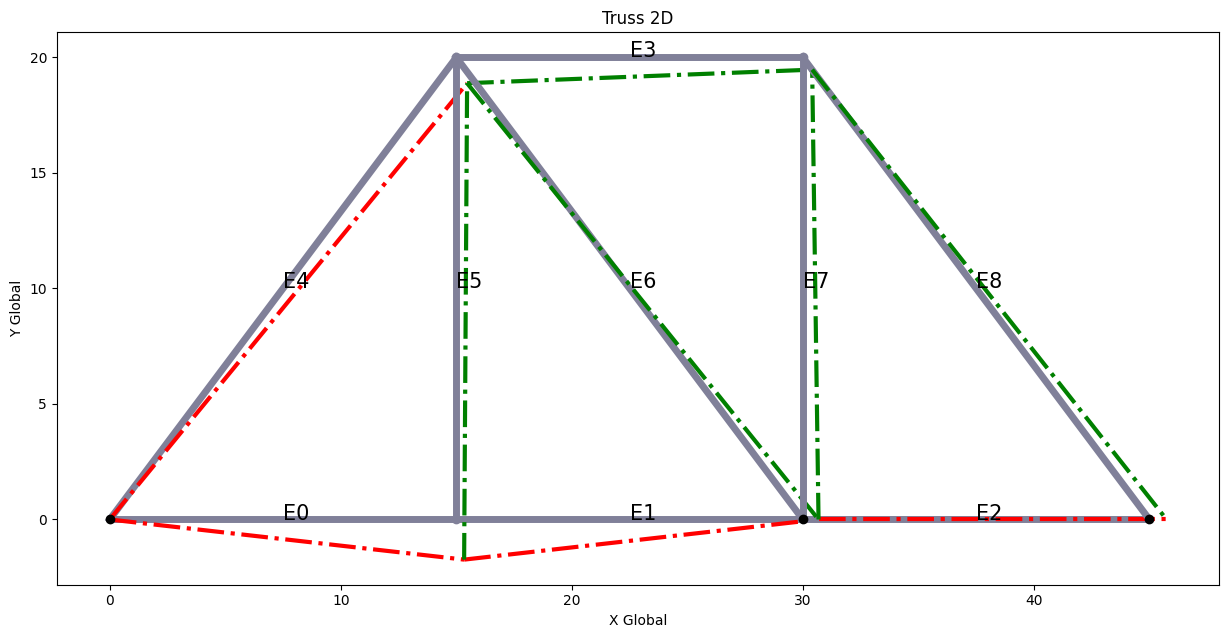

In [13]:
Nnode = np.shape(N_XY)[0]

p = 0
for i in range(numelem):
    #Graficador de la armadura
    plt.plot([N_XY[ID[i,0]-1, 1], N_XY[ID[i,1]-1, 1]], [N_XY[ID[i,0]-1, 2], N_XY[ID[i,1]-1, 2]], color=[.50, .50, .60], linewidth=5)

    #Graficador de la armadura deformada
    if acc_elem_L[p] > 0:
        #Elementos en compresion en verde
        plt.plot([Delta_node[ID[i,0]-1, 0], Delta_node[ID[i,1]-1, 0]], [Delta_node[ID[i,0]-1, 1], Delta_node[ID[i,1]-1 , 1]], 'g-.', linewidth=3)
    else:
        #Elementos a tension en rojo
        plt.plot([Delta_node[ID[i,0]-1, 0], Delta_node[ID[i,1]-1, 0]], [Delta_node[ID[i,0]-1, 1], Delta_node[ID[i,1]-1, 1]], 'r-.', linewidth=3)
    
    plt.title('Truss 2D')
    plt.xlabel('X Global')
    plt.ylabel('Y Global')
    plt.text((N_XY[ID[i, 0]-1, 1] + N_XY[ID[i, 1]-1, 1]) / 2, (N_XY[ID[i, 0]-1, 2] + N_XY[ID[i, 1]-1, 2]) / 2, f'E{i}', color='k', fontsize=15)

    p+=2

#Graficador de los nodos
for i in range(Nnode):
    if N_XY[i, 3] == 0 and N_XY[i, 4] == 0:
        plt.plot(N_XY[i, 1], N_XY[i, 2], 'o', color=[.50, .50, .60], markersize=6)
    else:
        plt.plot(N_XY[i, 1], N_XY[i, 2], 'ko', markersize=6)

fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.gca().set_aspect('equal')
plt.grid(False)
plt.show()